In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
import quantecon as qe
from interpolation import interp
from numba import njit, float64
from numba.experimental import jitclass
from quantecon.optimize import brentq

In [2]:
def v_star(y, α, β, μ):
    """
    True value function
    """
    c1 = np.log(1 - α * β) / (1 - β)
    c2 = (μ + α * np.log(α * β)) / (1 - α)
    c3 = 1 / (1 - β)
    c4 = 1 / (1 - α * β)
    return c1 + c2 * (c3 - c4) + c4 * np.log(y)

def σ_star(y, α, β):
    """
    True optimal policy
    """
    return (1 - α * β) * y

In [3]:
opt_growth_data = [
    ('alpha', float64),          # Production parameter
    ('beta', float64),          # Discount factor
    ('mu', float64),          # Shock location parameter
    ('s', float64),          # Shock scale parameter
    ('grid', float64[:]),    # Grid (array)
    ('shocks', float64[:])   # Shock draws (array)
]

@jitclass(opt_growth_data)
class OptimalGrowthModel:

    def __init__(self,
                alpha=0.4,
                beta=0.96,
                mu=0,
                s=0.1,
                grid_max=4,
                grid_size=120,
                shock_size=250,
                seed=1234):

        self.alpha, self.beta, self.mu, self.s = alpha, beta, mu, s

        # Set up grid
        self.grid = np.linspace(1e-5, grid_max, grid_size)

        # Store shocks (with a seed, so results are reproducible)
        np.random.seed(seed)
        self.shocks = np.exp(mu + s * np.random.randn(shock_size))


    def f(self, k):
        "The production function"
        return k**self.alpha

    def u(self, c):
        "The utility function"
        return np.log(c)

    def f_prime(self, k):
        return self.alpha * (k ** (self.alpha-1))

    def u_prime(self, c):
        return 1/c

    def u_prime_inv(self, c):
        return 1/c

In [4]:
@njit
def K(sigma_array, og):
    y = og.grid + sigma_array
    sigma = lambda x: interp(y, sigma_array, x)
    c = np.empty_like(og.grid)

    for i, k in enumerate(og.grid):
        vals = og.u_prime(sigma(og.f(k) * og.shocks)) * og.f_prime(k) * og.shocks
        c[i] = og.u_prime_inv(og.beta * np.mean(vals))

    return c

In [5]:
og = OptimalGrowthModel()

In [6]:
def solve_model_time_iter(og, sigma, tol=1e-4, max_iter=1000, verbose=True, print_skip=25):
    i = 0
    error = tol+1

    while i < max_iter and error > tol:
        sigma_new = K(sigma, og)
        error = np.max(np.abs(sigma - sigma_new))
        sigma = sigma_new
        i += 1

        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return sigma_new

In [7]:
sigma_init = np.copy(og.grid)
sigma = solve_model_time_iter(og, sigma_init)


Converged in 12 iterations.


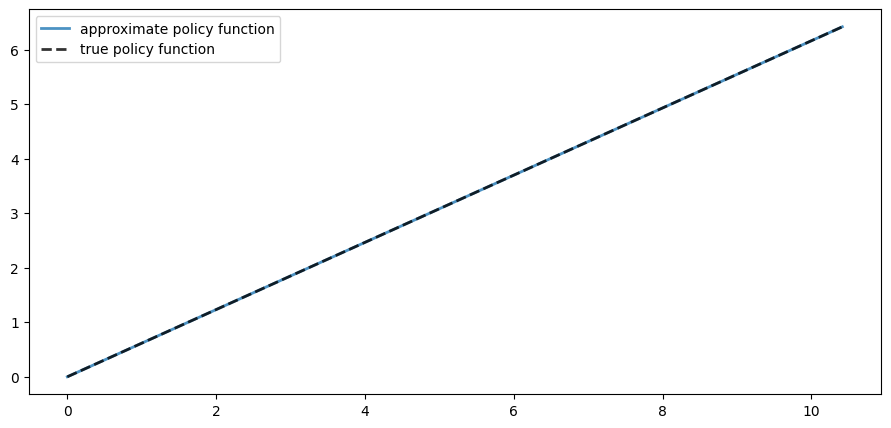

In [8]:
y = og.grid + sigma  # y_i = k_i + c_i

fig, ax = plt.subplots()

ax.plot(y, sigma, lw=2,
        alpha=0.8, label='approximate policy function')

ax.plot(y, σ_star(y, og.alpha, og.beta), 'k--',
        lw=2, alpha=0.8, label='true policy function')

ax.legend()
plt.show()